## Update
|version|update|cv|lb|
|:--|:--|--:|--:|
|v3|-|-|0.343|
|v4|increase N_ROWS from 90M to 180M|0.573|0.465|
|v5|increase N_SAMPLES from 1M to 2M<br>change to a larger model (5M -> 10M)|0.622|0.486|
|v8|Add normalization commented by [@hengck23](https://www.kaggle.com/hengck23)|0.629|0.496|

In [ ]:
!pip install rdkit
!pip install -U /kaggle/input/lightning-2-2-1/lightning-2.2.1-py3-none-any.whl

In [ ]:
from pathlib import Path

import numpy as np
import polars as pl
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics import AveragePrecision
import lightning as L
from lightning.pytorch.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    TQDMProgressBar,
)
from transformers import AutoConfig, AutoTokenizer, AutoModel, DataCollatorWithPadding
import datasets
from rdkit import Chem

# Hyper-Parameters

In [3]:
DEBUG = False
NORMALIZE = True
N_ROWS = 180_000_000
assert N_ROWS is None or N_ROWS % 3 == 0
if DEBUG:
    N_SAMPLES = 10_000
else:
    N_SAMPLES = 2_000_000
PROTEIN_NAMES = ["BRD4", "HSA", "sEH"]
data_dir = Path("/kaggle/input/leash-BELKA")
model_name = "DeepChem/ChemBERTa-10M-MTR"
batch_size = 256
trainer_params = {
  "max_epochs": 5,
  "enable_progress_bar": True,
  "accelerator": "auto",
  "precision": "16-mixed",
  "gradient_clip_val": None,
  "accumulate_grad_batches": 1,
  "devices": [-1],
}

# Prepare Dataset

In [4]:
df = pl.read_parquet(
    Path(data_dir, "train.parquet"),
    columns=["molecule_smiles", "protein_name", "binds"],
    n_rows=N_ROWS,
)
test_df = pl.read_parquet(
    Path(data_dir, "test.parquet"),
    columns=["molecule_smiles"],
    n_rows=10000 if DEBUG else None,
)
df.head()

molecule_smiles,protein_name,binds
str,str,i64
"""C#CCOc1ccc(CNc…","""BRD4""",0
"""C#CCOc1ccc(CNc…","""HSA""",0
"""C#CCOc1ccc(CNc…","""sEH""",0
"""C#CCOc1ccc(CNc…","""BRD4""",0
"""C#CCOc1ccc(CNc…","""HSA""",0


In [5]:
dfs = []
for i, protein_name in enumerate(PROTEIN_NAMES):
    sub_df = df[i::3]
    sub_df = sub_df.rename({"binds": protein_name})
    if i == 0:
        dfs.append(sub_df.drop(["protein_name"]))
    else:
        dfs.append(sub_df[[protein_name]])
df = pl.concat(dfs, how="horizontal")
df = df.sample(n=N_SAMPLES)
print(df.head())
print(df[PROTEIN_NAMES].sum())

shape: (5, 4)
┌───────────────────────────────────┬──────┬─────┬─────┐
│ molecule_smiles                   ┆ BRD4 ┆ HSA ┆ sEH │
│ ---                               ┆ ---  ┆ --- ┆ --- │
│ str                               ┆ i64  ┆ i64 ┆ i64 │
╞═══════════════════════════════════╪══════╪═════╪═════╡
│ COC(CNc1nc(NCCC2CCOC2)nc(N[C@@H]… ┆ 0    ┆ 0   ┆ 0   │
│ COC(=O)c1ccc(Nc2nc(Nc3n[nH]c4cc(… ┆ 0    ┆ 0   ┆ 0   │
│ CCC(CNc1nc(Nc2nc3ccccc3s2)nc(Nc2… ┆ 0    ┆ 0   ┆ 0   │
│ Cc1ccc(Nc2nc(NCC=C(Cl)Cl)nc(Nc3c… ┆ 0    ┆ 0   ┆ 0   │
│ CCOc1cc(Nc2nc(NCc3ccccc3CS(=O)(=… ┆ 0    ┆ 0   ┆ 0   │
└───────────────────────────────────┴──────┴─────┴─────┘
shape: (1, 3)
┌──────┬──────┬───────┐
│ BRD4 ┆ HSA  ┆ sEH   │
│ ---  ┆ ---  ┆ ---   │
│ i64  ┆ i64  ┆ i64   │
╞══════╪══════╪═══════╡
│ 9906 ┆ 8435 ┆ 19920 │
└──────┴──────┴───────┘


In [6]:
s=df['molecule_smiles']
s

molecule_smiles
str
"""COC(CNc1nc(NCC…"
"""COC(=O)c1ccc(N…"
"""CCC(CNc1nc(Nc2…"
"""Cc1ccc(Nc2nc(N…"
"""CCOc1cc(Nc2nc(…"
…
"""CC(CNc1nc(Nc2n…"
"""Cc1cc(C#N)cnc1…"
"""Cc1ccc(CNc2nc(…"


In [7]:
s[0]

'COC(CNc1nc(NCCC2CCOC2)nc(N[C@@H](Cc2ccc(F)cc2)C(=O)N[Dy])n1)C1CCCOC1'

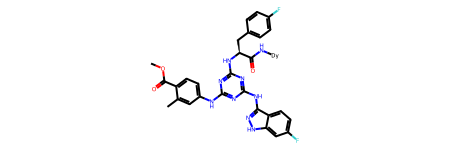

In [8]:
mol0=Chem.MolFromSmiles(s[1])
mol0

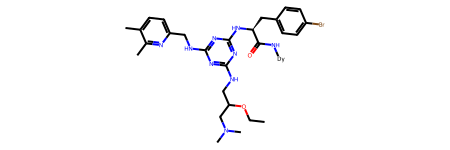

In [9]:
mol1=Chem.MolFromSmiles(s[5])
mol1

In [11]:
smiles1=Chem.MolToSmiles(mol1, canonical=True, isomericSmiles=False)
smiles1

'CCOC(CNc1nc(NCc2ccc(C)c(C)n2)nc(NC(Cc2ccc(Br)cc2)C(=O)N[Dy])n1)CN(C)C'

In [12]:
s[5]

'CCOC(CNc1nc(NCc2ccc(C)c(C)n2)nc(N[C@@H](Cc2ccc(Br)cc2)C(=O)N[Dy])n1)CN(C)C'

In [13]:
def normalize(x):
    mol = Chem.MolFromSmiles(x)
    smiles = Chem.MolToSmiles(mol, canonical=True, isomericSmiles=False)
    return smiles


if NORMALIZE:
    df = df.with_columns(pl.col("molecule_smiles").map_elements(normalize, return_dtype=pl.Utf8))
    test_df = test_df.with_columns(pl.col("molecule_smiles").map_elements(normalize, return_dtype=pl.Utf8))

In [14]:
train_idx, val_idx = train_test_split(np.arange(len(df)), test_size=0.2)
train_df, val_df = df[train_idx], df[val_idx]
len(train_df), len(val_df)

(1600000, 400000)

In [15]:
train_df.write_parquet('train_df.parquet', compression='snappy')
val_df.write_parquet('test_df.parquet', compression='snappy')

# Build Dataset

In [4]:
train_df = pl.read_parquet('/kaggle/input/processed-dataframe/train_df.parquet')
val_df=pl.read_parquet('/kaggle/input/processed-dataframe/test_df.parquet')

test_df = pl.read_parquet(
    Path(data_dir, "test.parquet"),
    columns=["molecule_smiles"],
    n_rows=10000 if DEBUG else None,
)

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.26k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

In [25]:
l=str(train_df[3233]["molecule_smiles"])
l

'shape: (1,)\nSeries: \'molecule_smiles\' [str]\n[\n\t"Cc1cc(Cl)nc(Cl…\n]'

In [26]:
print(len(l))

65


In [27]:
output0=tokenizer(l, truncation=True)
output0

{'input_ids': [12, 42, 206, 17, 20, 18, 34, 42, 44, 15, 42, 42, 42, 16, 15, 20, 15, 15, 17, 16, 18, 25, 15, 17, 16, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [28]:
o1=output0['input_ids']
print(len(o1))
m1=output0['attention_mask']
print(len(m1))

26
26


In [6]:
def tokenize(batch, tokenizer):
    output = tokenizer(batch["molecule_smiles"], truncation=True)
    return output

In [8]:
train_df[132,PROTEIN_NAMES]

BRD4,HSA,sEH
i64,i64,i64
0,0,0


In [9]:
train_df[132,PROTEIN_NAMES].to_numpy()

array([[0, 0, 0]])

In [10]:
train_df[132,PROTEIN_NAMES].to_numpy()[0]

array([0, 0, 0])

In [11]:
class LMDataset(Dataset):
    def __init__(self, df, tokenizer, stage="train"):
        assert stage in ["train", "val", "test"]
        self.tokenizer = tokenizer
        self.stage = stage
        df = (
            datasets.Dataset
            .from_pandas(df.to_pandas())
            .map(tokenize, batched=True, fn_kwargs={"tokenizer": self.tokenizer})
            .to_pandas()
        )
        self.df = pl.from_pandas(df)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        data = self._generate_data(index)
        data["label"] = self._generate_label(index)
        return data        

    def _generate_data(self, index):
        data = {
            "input_ids": np.array(self.df[index, "input_ids"]),
            "attention_mask": np.array(self.df[index, "attention_mask"]),
        }
        return data
    
    def _generate_label(self, index):
        if self.stage == "test":
            return np.array([0, 0, 0])
        else:
            return self.df[index, PROTEIN_NAMES].to_numpy()[0]


LMDataset(train_df[:100], tokenizer)[0]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

{'input_ids': array([12, 16, 16, 25, 20, 15, 15, 17, 23, 15, 21, 25, 15, 17, 23, 16, 16,
        15, 26, 25, 15, 15, 25, 26, 16, 17, 27, 18, 27, 18, 25, 15, 17, 23,
        16, 26, 17, 16, 17, 22, 19, 18, 23, 18, 16, 16, 16, 16, 26, 18, 25,
        21, 18, 15, 17, 16, 18, 25, 20, 13], dtype=int32),
 'attention_mask': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8),
 'label': array([0, 0, 0])}

In [13]:
s=LMDataset(train_df[:200], tokenizer)
s[23]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'input_ids': array([12, 16, 15, 20, 15, 15, 17, 23, 15, 21, 25, 15, 17, 23, 16, 15, 26,
        15, 15, 15, 15, 17, 16, 17, 22, 19, 18, 23, 18, 15, 26, 18, 25, 15,
        17, 23, 16, 15, 26, 15, 25, 32, 15, 15, 15, 15, 17, 27, 18, 15, 32,
        25, 26, 18, 25, 21, 18, 15, 25, 15, 20, 54, 13], dtype=int32),
 'attention_mask': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       dtype=int8),
 'label': array([0, 0, 0])}

In [ ]:
class LBDataModule(L.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, tokenizer):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.tokenizer = tokenizer

    def _generate_dataset(self, stage):
        if stage == "train":
            df = self.train_df
        elif stage == "val":
            df = self.val_df
        elif stage == "test":
            df = self.test_df
        else:
            raise NotImplementedError
        dataset = LMDataset(df, self.tokenizer, stage=stage)
        return dataset

    def _generate_dataloader(self, stage):
        dataset = self._generate_dataset(stage)
        if stage == "train":
            shuffle=True
            drop_last=True
        else:
            shuffle=False
            drop_last=False
        return DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            drop_last=drop_last,
            pin_memory=True,
            collate_fn=DataCollatorWithPadding(self.tokenizer),
        )

    def train_dataloader(self):
        return self._generate_dataloader("train")

    def val_dataloader(self):
        return self._generate_dataloader("val")

    def test_dataloader(self):
        return self._generate_dataloader("test")
    
    
datamodule = LBDataModule(train_df, val_df, test_df, tokenizer)

# Build Model

In [ ]:
class LMModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name, num_labels=3)
        self.lm = AutoModel.from_pretrained(model_name, add_pooling_layer=False)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.config.hidden_size, self.config.num_labels)
        self.loss_fn = nn.BCEWithLogitsLoss(reduction="mean")

    def forward(self, batch):
        last_hidden_state = self.lm(
            batch["input_ids"],
            attention_mask=batch["attention_mask"],
        ).last_hidden_state
        logits = self.classifier(
            self.dropout(last_hidden_state[:, 0])
        )
        return {
            "logits": logits,
        }

    def calculate_loss(self, batch):
        output = self.forward(batch)
        loss = self.loss_fn(output["logits"], batch["labels"].float())
        output["loss"] = loss
        return output

    
LMModel(model_name)

In [ ]:
class LBModelModule(L.LightningModule):
    def __init__(self, model_name):
        super().__init__()
        self.model = LMModel(model_name)
        self.map = AveragePrecision(task="binary")

    def forward(self, batch):
        return self.model(batch)

    def calculate_loss(self, batch, batch_idx):
        return self.model.calculate_loss(batch)

    def training_step(self, batch, batch_idx):
        ret = self.calculate_loss(batch, batch_idx)
        self.log("train_loss", ret["loss"], on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        return ret["loss"]

    def validation_step(self, batch, batch_idx):
        ret = self.calculate_loss(batch, batch_idx)
        self.log("val_loss", ret["loss"], on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.map.update(F.sigmoid(ret["logits"]), batch["labels"].long())

    def on_validation_epoch_end(self):
        val_map = self.map.compute()
        self.log("val_map", val_map, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.map.reset()

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self.forward(batch)["logits"]
        probs = F.sigmoid(logits)
        return probs

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        return {
            "optimizer": optimizer,
        }

    
modelmodule = LBModelModule(model_name)

# Training

In [ ]:
checkpoint_callback = ModelCheckpoint(
    filename=f"model-{{val_map:.4f}}",
    save_weights_only=True,
    monitor="val_map",
    mode="max",
    dirpath="/kaggle/working",
    save_top_k=1,
    verbose=1,
)
early_stop_callback = EarlyStopping(monitor="val_map", mode="max", patience=3)
progress_bar_callback = TQDMProgressBar(refresh_rate=1)
callbacks = [
    checkpoint_callback,
    early_stop_callback,
    progress_bar_callback,
]

In [ ]:
trainer = L.Trainer(callbacks=callbacks, **trainer_params)
trainer.fit(modelmodule, datamodule)

# Inference

In [ ]:
test_df = pl.read_parquet(
    Path(data_dir, "test.parquet"),
    columns=["molecule_smiles"],
    n_rows=10000 if DEBUG else None,
)

In [ ]:
working_dir = Path("/kaggle/working")
model_paths = working_dir.glob("*.ckpt")
test_dataloader = datamodule.test_dataloader()
for model_path in model_paths:
    print(model_path)
    modelmodule = LBModelModule.load_from_checkpoint(
        checkpoint_path=model_path,
        model_name=model_name,
    )
    predictions = trainer.predict(modelmodule, test_dataloader)
    predictions = torch.cat(predictions).numpy()
    pred_dfs = []
    for i, protein_name in enumerate(PROTEIN_NAMES):
        pred_dfs.append(
            test_df.with_columns(
                pl.lit(protein_name).alias("protein_name"),
                pl.lit(predictions[:, i]).alias("binds"),
            )
        )
    pred_df = pl.concat(pred_dfs)
    submit_df = (
        pl.read_parquet(Path(data_dir, "test.parquet"), columns=["id", "molecule_smiles", "protein_name"])
        .join(pred_df, on=["molecule_smiles", "protein_name"], how="left")
        .select(["id", "binds"])
        .sort("id")
    )
    submit_df.write_csv(Path(working_dir, f"submission_{model_path.stem}.csv"))

# Ensemble

In [ ]:
sub_files = list(working_dir.glob("submission_*.csv"))
sub_files

In [ ]:
sub_dfs = []
for sub_file in sub_files:
    sub_dfs.append(pl.read_csv(sub_file))
submit_df = (
    pl.concat(sub_dfs)
    .group_by("id")
    .agg(pl.col("binds").mean())
    .sort("id")
)

In [ ]:
!rm -fr *

In [ ]:
submit_df.write_csv(Path(working_dir, "submission.csv"))

## Future Directions
- Finding the optimal CV strategy
- Increase data
- Utilize buildingblock1 ~ buildingblock3
- Large-scale models
- Tune hyper-parameters
- Ensemble
- etc...